<h1>Build feature and output arrays

In [19]:
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import OneHotEncoder
import joblib

case = 7
if case == 1: # standard case
    folder = "parameters1_standard"
elif case == 2: # penalty term with penalty_weight = 10000
    folder = "parameters2_penalty_10000"
elif case == 3: # only synthetic data
    folder = "parameters3_synthetic"
elif case == 4: # real and synthetic data, synthetic data amount is 10 % of real data
    folder = "parameters4_mixed"
elif case == 5: # scaled capacity range
    folder = "parameters5_scaling"
elif case == 6: # penalty term with penalty_weight = 10000, only 100,000 data points
    folder = "parameters6_penalty_10000small"
elif case == 7: # penalty term with penalty_weight = 0.0001
    folder = "parameters7_penalty_0.001"

# lists for all data
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

if case != 3:
    with open(r"E:\MA_data\WPPs+production+reanalysis\WPPs+production+wind_new.json", "r", encoding="utf-8") as file:
        WPP_production_wind = json.load(file)

    # collect data
    for wpp in WPP_production_wind:
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Production"])

if case == 3 or case == 4:
    with open(f"../data/synthetic,power_curves/synthetic_data.json", "r", encoding="utf-8") as file:
        WPP_production_wind_synthetic = json.load(file)

    # collect data
    for wpp in WPP_production_wind_synthetic:
        all_turbine_types.append(str(wpp["Turbine"]))
        all_hub_heights.append(wpp["Hub_height"])
        all_capacities.append(wpp["Capacity"])
        all_commissioning_dates.append(f"{wpp['Commissioning_date']}/06" if isinstance(wpp["Commissioning_date"], str) and "/" not in wpp["Commissioning_date"] else wpp["Commissioning_date"])
        all_production_data.append(wpp["Production"])

if case == 5:

    # Load The Wind Power data
    df = pd.read_parquet("../data/data_hosting/The_Wind_Power.parquet")
    capacities_forecasting = df['Total power'].values / 1e3  # Convert to MW

    # Calculate min and max for both datasets
    min_training = np.min(all_capacities) # 8
    max_training = np.max(all_capacities) # 407

    min_forecasting = np.min(capacities_forecasting) # 0.1
    max_forecasting = 50 #np.max(capacities_forecasting) # 1386

    min_scaling_factor = min_forecasting / min_training # 0.00769
    max_scaling_factor = max_forecasting / max_training # 1.13793

    # Pre-calculate scaling factors for all capacities
    scaling_factors = [min_scaling_factor + (max_scaling_factor - min_scaling_factor) *
                    (cap - min_training) / (max_training - min_training) for cap in all_capacities]

    # Rescale capacities using pre-calculated scaling factors
    rescaled_capacities = [cap * scale for cap, scale in zip(all_capacities, scaling_factors)]


# One-Hot-Encoding for turbine types
encoder = OneHotEncoder(sparse_output=False)
turbine_types_onehot = encoder.fit_transform(np.array(all_turbine_types).reshape(-1, 1))

# convert to datetime
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# calculate age
ref_date = pd.Timestamp("2024-12-01")
ages = ref_date.year * 12 + ref_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# create combined features and output lists
combined_features_raw = []
output_raw = []

# convert data in feature arrays
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Repetitions for common features
    turbine_type_repeated = np.tile(turbine_types_onehot[idx], (num_rows, 1))
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    if case == 6:
        capacity_repeated = np.full((num_rows, 1), rescaled_capacities[idx])# Rescaled capacities
    else:
        capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extract production values and wind speeds
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    if case == 6:
        production_values = production_values * scaling_factors[idx] # Scale production values using the same factor as capacities
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    # combine all features
    combined_chunk = np.hstack((
        turbine_type_repeated,
        hub_height_repeated,
        capacity_repeated,
        age_repeated,
        wind_speeds
    ))

    # add the data
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

joblib.dump(encoder, f"{folder}/encoder.pkl")

# combine all data chunks to one array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)

# round all values to two decimal places
combined_features_raw = np.round(combined_features_raw, decimals=4)
output_raw = np.round(output_raw, decimals=4)

<h1>Scale feature vector and define Dataset

In [20]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
import torch
import joblib

if case == 6:
    random_indices = np.random.choice(combined_features_raw.shape[0], 100_000, replace=False)
    combined_features = combined_features_raw[random_indices]
    output = output_raw[random_indices]
else:
    combined_features = combined_features_raw
    output = output_raw


# Separate Scaler für jedes Feature
scaler_wind = StandardScaler()
scaler_ages = StandardScaler()
scaler_capacities = StandardScaler()
scaler_hub_heights = StandardScaler()

# Skalieren der einzelnen Features
combined_features[:, -1] = scaler_wind.fit_transform(combined_features[:, -1].reshape(-1, 1)).flatten() # scale wind speeds
combined_features[:, -2] = scaler_ages.fit_transform(combined_features[:, -2].reshape(-1, 1)).flatten()  # scale ages
combined_features[:, -3] = scaler_capacities.fit_transform(combined_features[:, -3].reshape(-1, 1)).flatten()  # scale capacities
combined_features[:, -4] = scaler_hub_heights.fit_transform(combined_features[:, -4].reshape(-1, 1)).flatten()  # scale hub heights

# Speichere alle Scaler in einem Dictionary
scalers = {
    "winds": scaler_wind,
    "ages": scaler_ages,
    "capacities": scaler_capacities,
    "hub_heights": scaler_hub_heights,
}

# Speichere das Dictionary mit Joblib
joblib.dump(scalers, f"{folder}/scalers.pkl")

# Dataset-Klasse für PyTorch
class WindPowerDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.targets[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Erstellung der PyTorch-Datasets
dataset = WindPowerDataset(combined_features, output)

<h1>Define Model

In [21]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3366)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation in the output layer for regression
        return x

<h1>Training, Testing and deployment in one</h1>
The computing resources on the personal PC are

• 4 physical CPU cores, with Hyper-Threading 4 additional virtual CPU cores --> 8 logical CPU cores

• 1 integrated GPU, that can be used with import torch_directml, device = torch_directml.device(), but it is much slower than the CPUs (and doesn't support HuberLoss: this calculation must be outsourced to the CPU. And no float64, only float32 datatypes)

In [ ]:
import torch
import torch.optim as optim
from torch.nn import HuberLoss, MSELoss, L1Loss
from torch.utils.data import DataLoader, random_split

params = {"batch_size": 128,
          "lr": 0.00010155,
          "number_epochs": 10}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

# Model
input_size = combined_features.shape[1]

# use static instead of dynamic computational graphs
model = torch.jit.script(MLP(input_size=input_size)).to(device)
model.to(device)

# Trainings-Konfiguration
mae_criterion = L1Loss()
mse_criterion = MSELoss()
huber_criterion = HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

# shuffling doesn't matter here, has already taken place during train_test_split
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False)

real_capacities = scaler_capacities.inverse_transform(combined_features[:, -3].reshape(-1, 1)).flatten()
rcm = real_capacities.mean()

penalty_weight = 0
if case == 2 or case == 6:
    penalty_weight = 10000
elif case == 7:
    penalty_weight = 0.001

# Training
for epoch in range(params["number_epochs"]):
    print(f"Epoch {epoch + 1}/{params['number_epochs']}")
    model.train()
    train_loss_mae, train_loss_mse, train_loss_huber = 0, 0, 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        if case in [2, 6, 7]:
            capacities = scaler_capacities.inverse_transform(batch_x[:, -3].reshape(-1, 1)).flatten()
            penalty = (outputs.detach().numpy() - capacities).sum()
        
        # Calculate metrics for each criterion
        loss_mae = mae_criterion(outputs, batch_y)
        loss_mse = mse_criterion(outputs, batch_y)
        loss_huber = huber_criterion(outputs, batch_y)
        if case in [2, 6, 7]:
            loss_huber += penalty_weight*penalty

        optimizer.zero_grad()
        loss_huber.backward()
        optimizer.step()

        # Accumulate metrics for logging
        train_loss_mae += loss_mae.item()
        train_loss_mse += loss_mse.item()
        train_loss_huber += loss_huber.item()

    train_loss_mae /= len(train_loader)
    train_loss_mse /= len(train_loader)
    train_loss_huber /= len(train_loader)

print(f"Training metrics")
print(f"    absolute")
print(f"        Huber: {train_loss_huber}")
print(f"        MSE: {train_loss_mse}")
print(f"        MAE: {train_loss_mae}")
print(f"        RMSE: {np.sqrt(train_loss_mse)}")
print(f"    normalised")
print(f"        Huber: {train_loss_huber / rcm**(3/2)}")
print(f"        MSE: {train_loss_mse / rcm**2}")
print(f"        MAE: {train_loss_mae / rcm}")
print(f"        RMSE: {np.sqrt(train_loss_mse / rcm**2)}")

# Testen
model.eval()

test_loss_mae, test_loss_mse, test_loss_huber = 0, 0, 0

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        preds = model(batch_x)
        
        test_loss_mae += mae_criterion(preds, batch_y).item()
        test_loss_mse += mse_criterion(preds, batch_y).item()
        test_loss_huber += huber_criterion(preds, batch_y).item()

test_loss_mae /= len(test_loader)
test_loss_mse /= len(test_loader)
test_loss_huber /= len(test_loader)

print(f"Testing metrics")
print(f"    absolute")
print(f"        Huber: {test_loss_huber}")
print(f"        MSE: {test_loss_mse}")
print(f"        MAE: {test_loss_mae}")
print(f"        RMSE: {np.sqrt(test_loss_mse)}")
print(f"    normalised")
print(f"        Huber: {test_loss_huber / rcm**(3/2)}")
print(f"        MSE: {test_loss_mse / rcm**2}")
print(f"        MAE: {test_loss_mae / rcm}")
print(f"        RMSE: {np.sqrt(test_loss_mse / rcm**2)}")

torch.save(model.state_dict(), f"{folder}/model.pth")
print(f"Model parameters saved")

torch.save(input_size, f"{folder}/input_size.pkl")
print(f"Input size saved")

metrics = {
    "Training": {
        "absolute": {
            "Huber": train_loss_huber,
            "MAE": train_loss_mae,
            "MSE": train_loss_mse,
            "RMSE": np.sqrt(test_loss_mse)
        },
        "normalised": {
            "Huber": train_loss_huber / rcm**(3/2),
            "MAE": train_loss_mae / rcm,
            "MSE": train_loss_mse / rcm**2,
            "RMSE": np.sqrt(train_loss_mse / rcm**2)
        }
    },
    "Testing": {
        "absolute": {
            "Huber": test_loss_huber,
            "MAE": test_loss_mae,
            "MSE": test_loss_mse,
            "RMSE": np.sqrt(test_loss_mse)
        },
        "normalised": {
            "Huber": test_loss_huber / rcm**(3/2),
            "MAE": test_loss_mae / rcm,
            "MSE": test_loss_mse / rcm**2,
            "RMSE": np.sqrt(test_loss_mse / rcm**2)
        }
    }
}

joblib.dump(metrics, f"{folder}/metrics.pkl")
print(f"metrics saved")

Epoch 1/10
Epoch 2/10


<h1>Scaled capacities, boxplot

C:\Users\alexa\AppData\Local\Temp\ipykernel_29616\605725633.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, patch_artist=True, labels=["Training WPPs scaled", "Forecasting WPPs", "Training WPPs"])


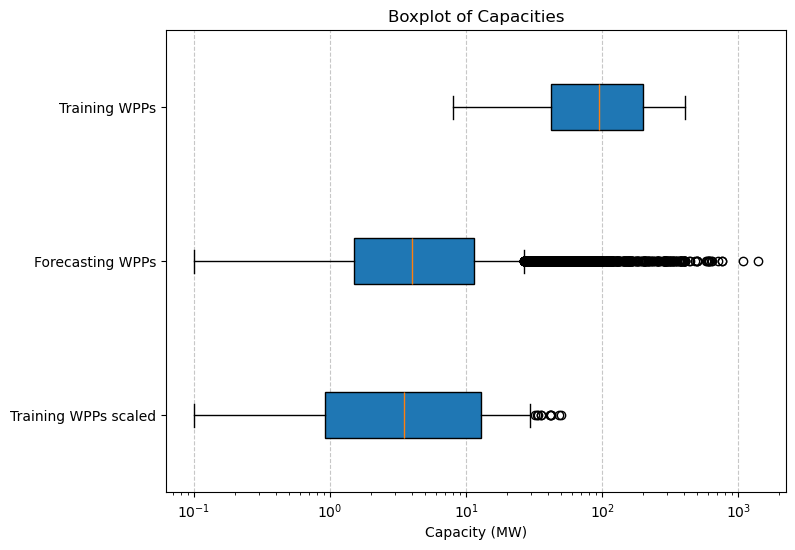

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_parquet("../data_hosting/The_Wind_Power.parquet")
capacities_the_wind_power = df['Total power'].values / 1e3  # Convert to MW

data = [rescaled_capacities, capacities_the_wind_power, all_capacities]

plt.figure(figsize=(8, 6))
plt.boxplot(data, vert=False, patch_artist=True, labels=["Training WPPs scaled", "Forecasting WPPs", "Training WPPs"])
plt.title("Boxplot of Capacities")
plt.xlabel("Capacity (MW)")
plt.xscale("log")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()